# **Tarea 5**

## **Parte 1: Posible algoritmo no supervisado aplicable a los datos**

**Isolation forest (IF)**

Recordando que los datos de estudios corresponden a transacciones clasificadas como ilícitas o legítimas, el objeto de estudio es identificar conforme partones anormales identificados si una transacción puediera tener el objetivo de lavar dinero.

Para ello, un algoritmo no supervisado que identifique atípicos puede ser de utilidad. Existen varios tipos de algoritmos de detección de anomalías, uno de los más utilizados es el **Isolation forest (IF)**. Este método tiene un requisito de memoria bajo, por lo que es adecuado para grandes volúmenes de información y funciona bien con problemas de grandes dimensiones con atributos irrelevantes.

Normalmente, para detectar anomalías se perfilan los datos normales y las anomalías serían aquellos datos que no encajan en ese perfil. Isolation Forest tiene otro enfoque - en lugar de construir un modelo de instancias normales, aísla explícitamente, mediante alguna característica aleatoria, los puntos anómalos en los datos. Las observaciones de anomalías están ubicadas más lejos de los puntos normales y deberían estar más cerca de la raíz ya que tienen un camino medio más corto.

En IF se siguen los siguientes dos pasos:

1: se utiliza un conjunto de datos de train para crear árboles aislados (iTrees),

2: cada muestra en el conjunto de datos se compila con iTrees del paso anterior y se asigna una puntuación de anomalía adecuada a la muestra.

La puntuación de anomalía se calcula de la siguiente manera:
$s(x,n)=2^{-\frac{E(h(x))}{c(n)}}$

Donde:
$h(x)$: longitud del camino de observación x

$c(n)$: longitud de ruta promedio de búsqueda fallida del árbol de búsqueda binaria y número de nodos externos

A cada observación se le asigna una “puntuación de anomalía”, teniendo en cuenta la siguiente decisión: si la puntuación es cercana a 1, se marca como anomalía (se etiquetan con -1). Las observaciones con una puntuación inferior a 0.5 se marcan como normales (se etiquetan como 1).

*Contaminación*: Es el parámetro más importante de IF; hace referencia a la proporción de valores atípicos en el conjunto de datos. Define el umbral de las puntuaciones de las muestras.

*n_estimators*: el número de estimadores base en el conjunto. El valor predeterminado es 100.

A diferencia de otros métodos de agrupación, IF no está diseñado para determinar grupos de datos, si no identificar anomalías y su resultado final es una puntuación para cada punto de datos en lugar de una asignación de grupo.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

Este método, en comparación con Isolation Forest, tiene como objetivo identificar áreas de alta densidad en los datos. Con base en ello, puede representar comportamientos comunes entre transacciones y aislar puntos de datos anómalos.

#### Conceptos importantes:

1. **Eps (ε):** parámetro de distancia que define el radio alrededor de un punto de datos para buscar vecinos cercanos.

2. **Densidad:** número de puntos dentro de un radio especificado ε.

3. **MinPts:** número mínimo de puntos requeridos para formar un cluster denso. Este parámetro se utiliza junto con ε para determinar si un punto es un punto central, de borde o de ruido.

4. **Noise point:** son puntos que no cumplen con los criterios de densidad (menos de MinPts dentro de su ε-vecindario) y no son parte de ningún cluster.

5. **Core point:** es un punto central si tiene al menos MinPts dentro de su ε-vecindario.

6. **Border point:** es un punto de borde si no es un punto central pero está en el vecindario de un punto central.

#### Pasos del Algoritmo DBSCAN:

1. **Identificación de Puntos Centrales:**
   - Para cada punto $x$, cuenta la cantidad de puntos que caen dentro de la distancia ε de $x$.
   - Si este número es mayor o igual a MinPts, $x$ se marca como un punto central.

2. **Formación de Clusters:**
   - Si un punto $y$ está dentro del ε-vecindario de un punto central $x$, $y$ se agrega al cluster de $x$.
   - Si $y$ es también un punto central, su ε-vecindario también se agrega al cluster, lo que puede hacer que el cluster crezca recursivamente.

3. **Identificación de Puntos de Borde y Ruido:**
   - Los puntos que no son centrales pero están dentro del ε-vecindario de un punto central se consideran *puntos de borde*.
   - Los puntos que no son centrales y no tienen MinPts en su ε-vecindario se consideran *ruido*.

La parte fundamental de DBSCAN es la noción de **densidad**, en el contexto de este método se refiere a la cardinalidad del conjunto de puntos dentro del ε-vecindario de un punto $x$, que generalmente se calcula usando la distancia euclidiana para datos de espacio continuo.

DBSCAN no requiere que se especifique el número de clusters de inicio, lo que es una gran ventaja sobre algoritmos como K-means, que requieren esa información a priori.

## **Parte 2: Algoritmo no supervisado y  métrica para determinar el número de clusters**

Se importan las librerías a utilizar.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

Se realiza la carga de datos. Tomamos el último archivo generado en la tarea 3, el cual ya está preprocesado en su mayoría.

In [2]:
# Carga de datos
trans=pd.read_csv('C:/Users/sandy/Downloads/trans_vf_2.csv')
# cambiamos el tipo de dato a datetime
trans['Timestamp'] = pd.to_datetime(trans['Timestamp'])

#trans.timestamp = trans.timestamp.values.astype(np.int64) / 10 ** 9
trans['Timestamp']=trans['Timestamp'].astype('int64')/10**9

De la tarea 4, concluimos excluir del análisis aquellas variables que brindaban información similar.

In [5]:
features = trans.drop(['R_CCY', 'Amount Received', 'Amount Paid'], axis=1)

In [11]:
# prueba con muestra de 10,000
#sample_data = features.sample(n=10000, random_state=42)

Se escalan los datos para el correcto manejo e interpretación de los mismos.

In [7]:
scaler=StandardScaler()
sample_scaled_features = scaler.fit_transform(features)

**Mini Batch K-Means**

Se probará el algoritmo **Mini Batch K-Means** al ser una variación del método de K-Means pero adaptado para grandes conjuntos de datos, ya que utiliza "batches" random de información para que puedan ser almacenados en la memoria reduciendo el tiempo de cómputo. Este algoritmo mantiene gran parte de las propiedades de K-Means, pero se ejecuta más rápido.

Para determinar el número óptimo de clusters, se utilizará el índice de Davies-Bouldin, una métrica que evalúa la calidad del clustering al ser un indicador de cuán bien se separan los diferentes clusters y cuán compactos son internamente. Este índice mide la similitud promedio de cada grupo con su grupo más similar, donde la similitud es la relación entre las distancias dentro del grupo y las distancias entre grupos.

El objetivo es minimizar el índice de Davies-Bouldin. Un valor bajo implica que los clusters están bien separados (es decir, la distancia entre los centroides es grande) y que son internamente compactos (es decir, los puntos están cerca de su centroide), lo cual es deseable en un buen clustering.

In [ ]:
# buscamos el número óptimo de cluesters
k_clusters = range(2, 12)  # 2 a 11 clusters
davies_bouldin_scores = []

for n_clusters in k_clusters:
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = minibatch_kmeans.fit_predict(sample_scaled_features)
    
    # índice de Davies-Bouldin
    db_score = davies_bouldin_score(sample_scaled_features, cluster_labels)
    davies_bouldin_scores.append(db_score)

# el mejor es el que minimiza el índice de Davies-Bouldin
best_n_clusters = k_clusters[np.argmin(davies_bouldin_scores)]
best_db_score = min(davies_bouldin_scores)

(best_n_clusters, best_db_score)


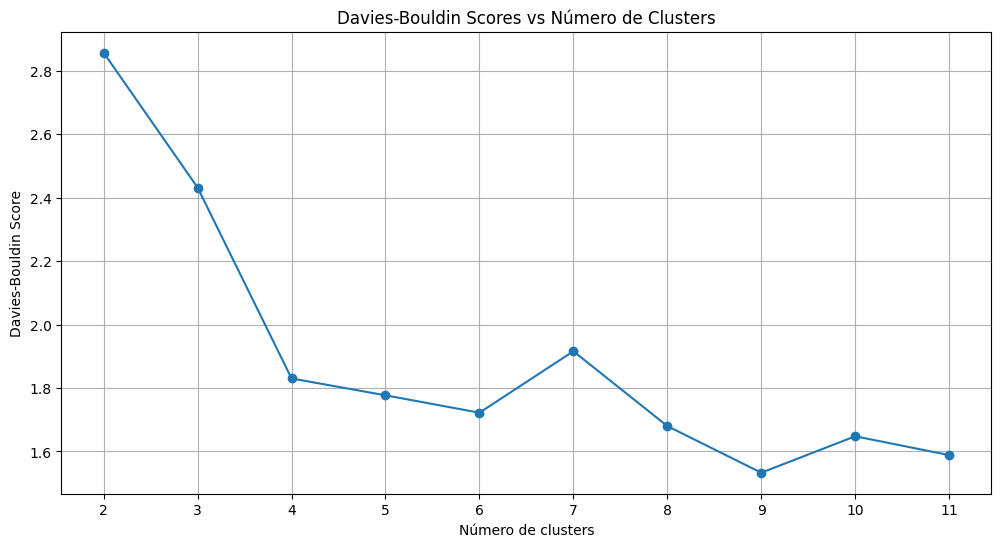

In [14]:
# Graficamos los resultados
plt.figure(figsize=(12, 6))
plt.plot(k_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores vs Número de Clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_clusters)
plt.grid(True)
plt.show()

**PCA**

Para visualizar los clusters, es necesario reducir la dimensionalidad. Para esto se hará uso de la técnica de Análisis de Componentes Principales (PCA por sus siglas en inglés), el cual tiene como objetivo conservar la mayor cantidad de información en menos "variables", las cuales están consideran una combinación lineal de las variables involucradas.

C:\Users\sandy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


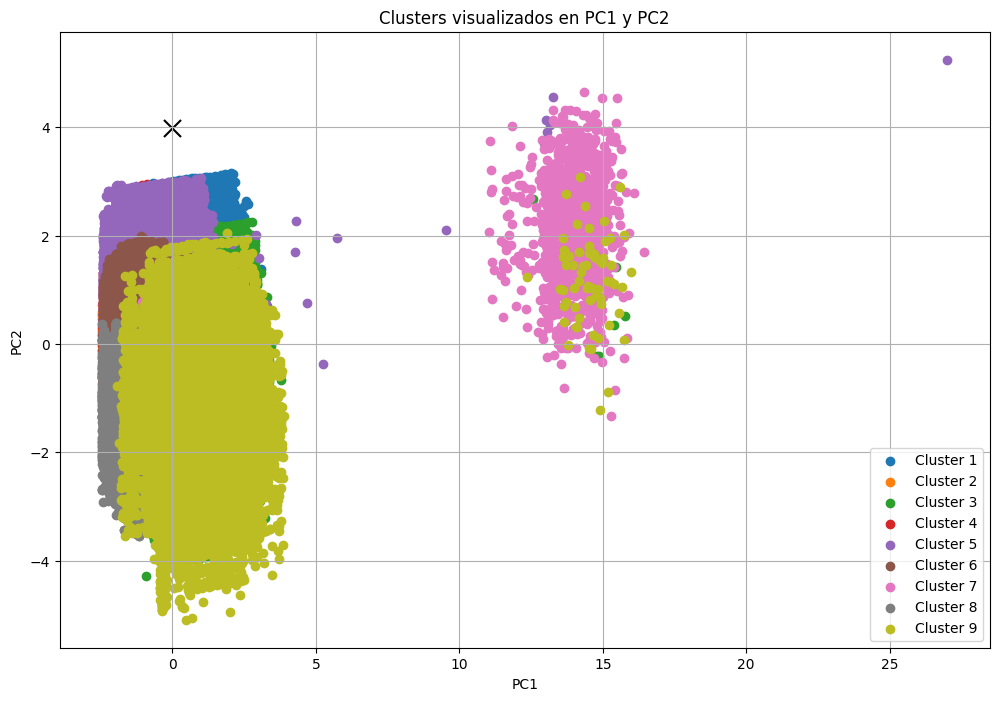

In [17]:
# MiniBatchKMeans con el número óptimo de clusters encontrado
minibatch_kmeans_optimal = MiniBatchKMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = minibatch_kmeans_optimal.fit_predict(sample_scaled_features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(sample_scaled_features)

# Graficamos los clusters en 2D
plt.figure(figsize=(12, 8))
for i in range(best_n_clusters):
    # Graficamos los puntos de datos y centramos los clusters
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i+1}')
    plt.scatter(minibatch_kmeans_optimal.cluster_centers_[i, 0], minibatch_kmeans_optimal.cluster_centers_[i, 1], 
                marker='x', s=150, c='black')

plt.title('Clusters visualizados en PC1 y PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


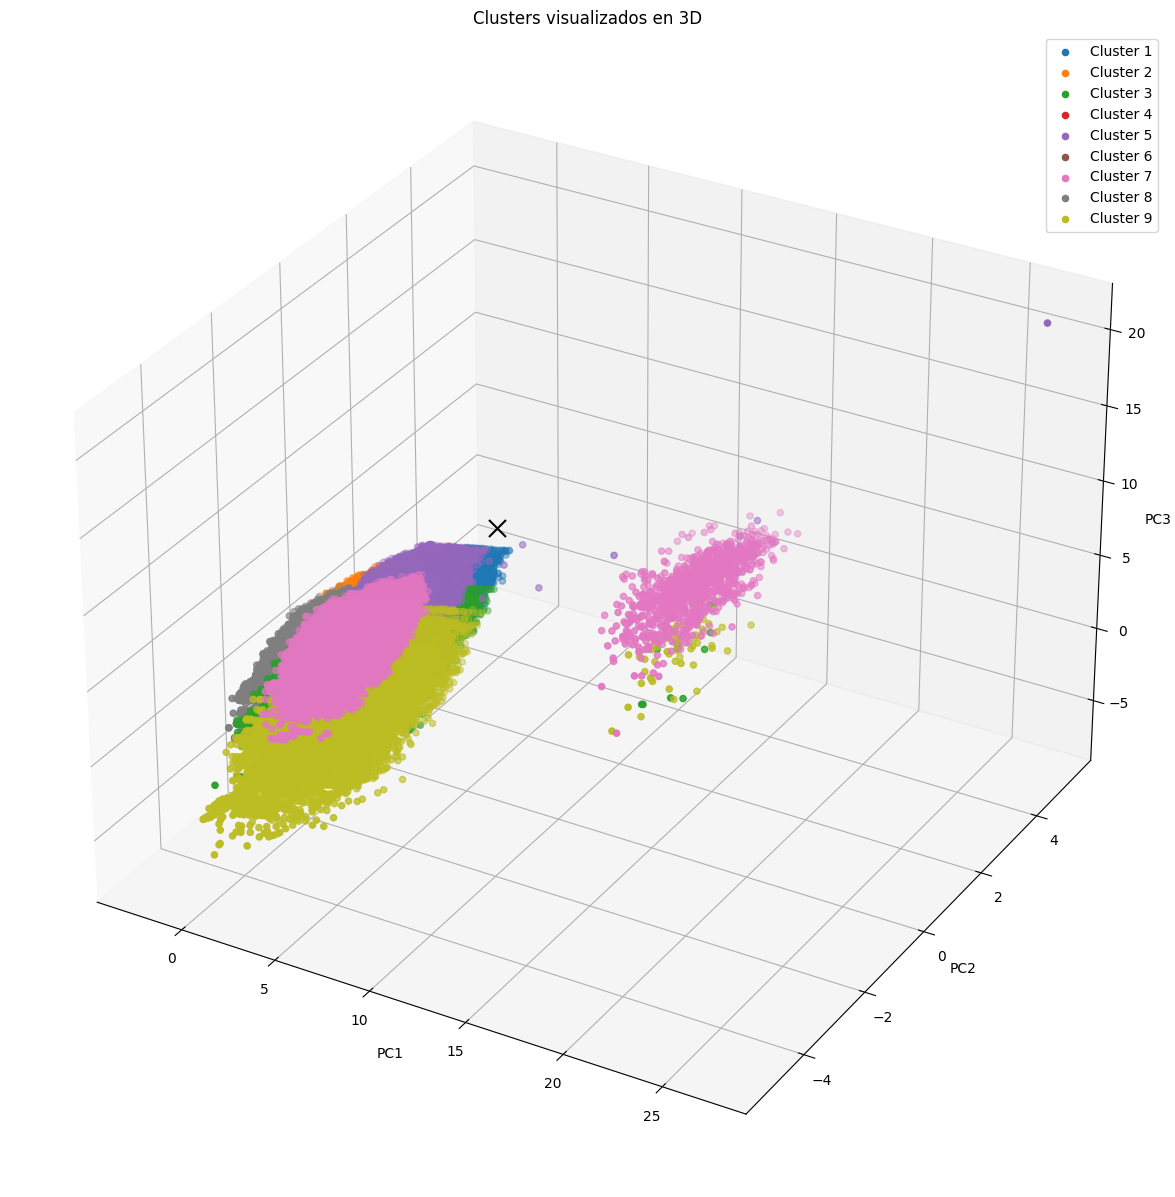

In [21]:
# PCA de 3 dimensiones en búsqueda de mejorar visualización de clusters
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(sample_scaled_features)

# Graficar los clusters en 3D
plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
for i in range(best_n_clusters):
    # Graficar los puntos de datos y centrar los clusters
    ax.scatter3D(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], reduced_features[cluster_labels == i, 2], label=f'Cluster {i+1}')
    ax.scatter3D(minibatch_kmeans_optimal.cluster_centers_[i, 0], minibatch_kmeans_optimal.cluster_centers_[i, 1], minibatch_kmeans_optimal.cluster_centers_[i, 2], 
                marker='x', s=150, c='black')

ax.set_title('Clusters visualizados en 3D')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

- https://engineering.teknasyon.com/what-are-isolation-forests-151d8e98ef5f

- https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/
